In [1]:
!pwd

/home/iir/work/ben/NCKU/IIR/IIR_SemEval-2013-task-9/IIR_Preprocessing


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
# Define the BERT tokenizer and model
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import os
from datetime import datetime
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/root/anaconda3/envs/augllms/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Data Preparation

In [4]:
path_data_train = "save_results/train_dataset.csv"
path_data_test = "save_results/test_dataset.csv"
data_train = pd.read_csv(path_data_train, sep=',', encoding='utf-8')
test_df = pd.read_csv(path_data_test, sep=',', encoding='utf-8')
le = LabelEncoder()
class_mapping = {
    'false': 0,
    'effect': 1,
    'mechanism': 2,
    'advise': 3,
    'int': 4
}
# Fit and transform the 'pair type' column using the custom mapping
data_train['pair type'] = le.fit_transform(data_train['pair type'].map(class_mapping))
test_df['pair type'] = le.fit_transform(test_df['pair type'].map(class_mapping))
# Split the data into training and validation sets
train_df, val_df = train_test_split(data_train, test_size=0.1, random_state=42)

In [5]:
train_df.shape, test_df.shape, val_df.shape

((41058, 4), (5716, 4), (4563, 4))

In [6]:
train_df.head()

,entity e1,entity e2,pair type,Full Sentence
3095,olanzapine,haloperidol,0,"In large, well controlled trials in patients w..."
39459,disopyramide,hexobarbital,0,There have been reports of interactions of ery...
8723,phenobarbital,valproic acid,0,"Similarly, the effects of phenytoin on phenoba..."
8541,chlordiazepoxide,diazepam,0,The most commonly occurring drug interactions ...
14576,acetaminophen,ketorolac tromethamine,0,"Therapeutic concentrations of digoxin, warfari..."


# Quick EDA

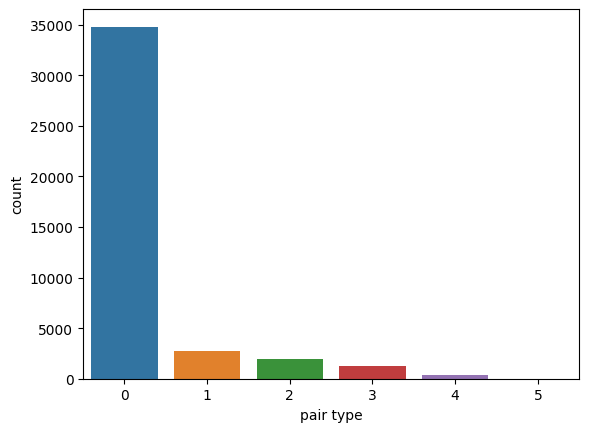

In [7]:
sns.countplot(data=train_df, x="pair type");

# Statistics about length of text

In [8]:
train_df['text_length'] = train_df['Full Sentence'].apply(len)
summary = train_df['text_length'].describe()
summary

count    41058.000000
mean       350.241390
std        254.331494
min         19.000000
25%        174.000000
50%        261.000000
75%        421.000000
max       1010.000000
Name: text_length, dtype: float64

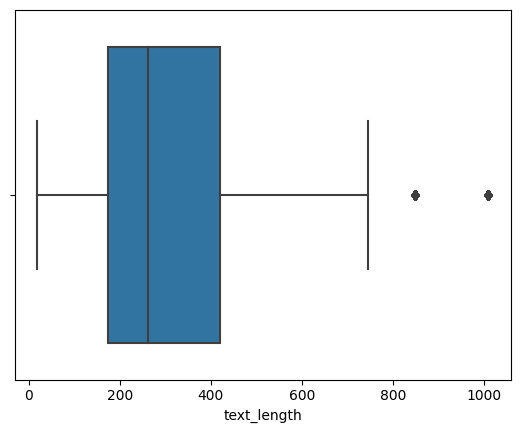

In [9]:
sns.boxplot(data=train_df, x='text_length');

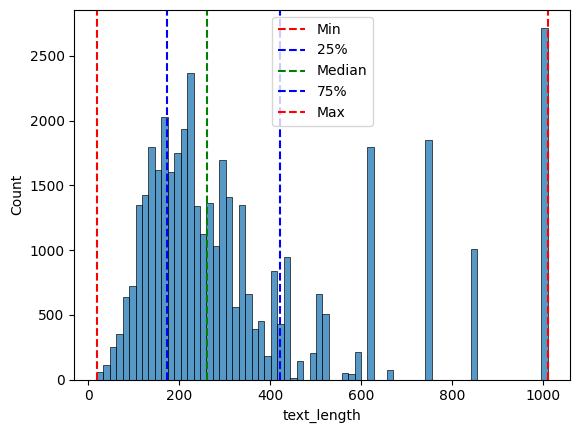

In [10]:
sns.histplot(data=train_df, x='text_length')
plt.axvline(summary['min'], color='r', linestyle='--', label='Min')
plt.axvline(summary['25%'], color='b', linestyle='--', label='25%')
plt.axvline(summary['50%'], color='g', linestyle='--', label='Median')
plt.axvline(summary['75%'], color='b', linestyle='--', label='75%')
plt.axvline(summary['max'], color='r', linestyle='--', label='Max')
plt.legend();

In [11]:
# Tokenize and encode the sentences
class MyDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.data = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = self.data.iloc[index]['Full Sentence']
        e1 = self.data.iloc[index]['entity e1']
        e2 = self.data.iloc[index]['entity e2']
        pair_type = self.data.iloc[index]['pair type']

        #input_text = f"{sentence} [SEP] {e1} [SEP] {e2}"
        input_text = f"{sentence} [SEP] {e1} [SEP] {e2}"

        encoding = self.tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': input_text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(pair_type, dtype=torch.long)
        }


# Tokenizer

In [12]:
# create an instance of the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
# set the batch size
batch_size = 100
num_epochs = 200  # Adjust as needed

# set the maximum sequence length
max_len = 150

# create data loaders for the training and validation sets
train_dataset = MyDataset(train_df, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MyDataset(val_df, tokenizer, max_len)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = MyDataset(test_df, tokenizer, max_len)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model

In [14]:
class BertSentimentClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertSentimentClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout1(pooled_output)
        output = self.fc1(pooled_output)
        output = self.dropout2(output)
        logits = self.fc2(output)

        return logits

In [15]:
bert_model_name = "bert-base-uncased"
num_classes = train_df["pair type"].nunique()
model = BertSentimentClassifier(bert_model_name, num_classes)
criterion = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Training


In [16]:
def train(model, data_loader, optimizer, criterion, device):
    # set the model to train mode
    model.train()

    # initialize the loss, accuracy, precision, recall, and f1_score variables
    total_loss, total_accuracy = 0, 0
    total_precision, total_recall, total_f1 = 0, 0, 0

    # iterate over the data loader
    for data in tqdm(data_loader):
        # move the inputs to the device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        # zero the gradient
        optimizer.zero_grad()

        # get the model's predictions
        outputs = model(input_ids, attention_mask)

        # get the loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # accuracy calculation
        logits = outputs.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        total_accuracy += flat_accuracy(logits, label_ids)

        # calculate precision, recall, and f1 score
        total_precision += precision_score(label_ids, np.argmax(logits, axis=1), average='weighted')
        total_recall += recall_score(label_ids, np.argmax(logits, axis=1), average='weighted')
        total_f1 += f1_score(label_ids, np.argmax(logits, axis=1), average='weighted')

        # perform backpropagation and optimization
        loss.backward()
        optimizer.step()

    # calculate the average loss, accuracy, precision, recall, and f1 score
    avg_loss = total_loss / len(data_loader)
    avg_acc = total_accuracy / len(data_loader)
    avg_precision = total_precision / len(data_loader)
    avg_recall = total_recall / len(data_loader)
    avg_f1 = total_f1 / len(data_loader)

    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1


In [17]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [18]:
def evaluate(model, data_loader, criterion, device):
    # set the model to eval mode
    model.eval()

    # initialize the loss, accuracy, precision, recall, and f1_score variables
    total_loss = 0
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0

    # iterate over the data loader
    for data in tqdm(data_loader):
        # move the inputs to the device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        # disable gradient computation
        with torch.no_grad():
            # get the model's predictions
            outputs = model(input_ids, attention_mask)

            # get the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # calculate the number of correct predictions
            logits = outputs.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            total_accuracy += flat_accuracy(logits, label_ids)

            # calculate precision, recall, and f1 score
            total_precision += precision_score(label_ids, np.argmax(logits, axis=1), average='weighted')
            total_recall += recall_score(label_ids, np.argmax(logits, axis=1), average='weighted')
            total_f1 += f1_score(label_ids, np.argmax(logits, axis=1), average='weighted')

    # calculate the average loss, accuracy, precision, recall, and f1 score
    avg_loss = total_loss / len(data_loader)
    accuracy = total_accuracy / len(data_loader)
    precision = total_precision / len(data_loader)
    recall = total_recall / len(data_loader)
    f1 = total_f1 / len(data_loader)

    return avg_loss, accuracy, precision, recall, f1

In [19]:
# Function to calculate F1 score, Precision, Recall
def calculate_metrics(predictions, labels):
    predictions = torch.argmax(predictions, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')

    return f1, precision, recall

In [ ]:
import warnings

# ...

# Ignore warnings
warnings.filterwarnings("ignore")

# Create a folder for logs if it doesn't exist
logs_folder = "logs"
os.makedirs(logs_folder, exist_ok=True)

# Generate a filename based on the current date and time
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_filename = f"{logs_folder}/training_log_{current_time}.txt"



# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set the learning rate
lr = 2e-5

# set the number of epochs


# set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# move the model to the device
model.to(device)

# lists to store metrics
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []

val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
test_f1_scores = []

best_val_loss = float('inf')
best_epoch = 0

# iterate over the epochs
# Set up logging
with open(log_filename, 'a') as log_file:
  for epoch in range(num_epochs):
      start_time = datetime.now()
      print(f'Epoch {epoch + 1}/{num_epochs}')

      # train the model
      train_loss, train_acc, train_precision, train_recall, train_f1 = train(model, train_loader, optimizer, criterion, device)

      # evaluate the model on the validation set
      val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate(model, val_loader, criterion, device)

          # evaluate the model on the validation set
      test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion, device)

      # print the detailed metrics
      print(f'Train -- Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f}')
      print(f'Val   -- Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}')
      print(f'Test  -- Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1: {test_f1:.4f}')

      # log the metrics
      log_file.write(f'Epoch {epoch + 1}/{num_epochs}\n')
      log_file.write(f'Train -- Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f}\n')
      log_file.write(f'Val   -- Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}\n')
      log_file.write(f'Test  -- Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1: {test_f1:.4f}\n')
      log_file.flush()

      # Save the best model based on validation loss
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_epoch = epoch + 1
          torch.save(model.state_dict(), f'best_model.pt')

      # Save the metrics
      train_accuracies.append(train_acc)
      train_losses.append(train_loss)
      train_precisions.append(train_precision)
      train_recalls.append(train_recall)
      train_f1_scores.append(train_f1)

      val_losses.append(val_loss)
      val_accuracies.append(val_acc)
      val_precisions.append(val_precision)
      val_recalls.append(val_recall)
      val_f1_scores.append(val_f1)

      test_losses.append(test_loss)
      test_accuracies.append(test_acc)
      test_precisions.append(test_precision)
      test_recalls.append(test_recall)
      test_f1_scores.append(test_f1)

      # Calculate and print time remaining
      elapsed_time = datetime.now() - start_time
      remaining_time = (num_epochs - epoch - 1) * elapsed_time
      print(f'Time Elapsed: {elapsed_time}, Time Remaining: {remaining_time} \n')

# Print the best epoch
print(f"Best Model: Epoch {best_epoch}, Best Validation Loss: {best_val_loss:.4f}")

print(f"Path log file: ", log_filename)


Epoch 1/200


100%|██████████| 58/58 [00:23<00:00,  2.42it/s]


Train -- Loss: 0.4087 | Acc: 0.8788 | Precision: 0.8313 | Recall: 0.8788 | F1: 0.8469
Val   -- Loss: 0.2336 | Acc: 0.9163 | Precision: 0.9086 | Recall: 0.9163 | F1: 0.9041
Test  -- Loss: 0.3449 | Acc: 0.8808 | Precision: 0.8645 | Recall: 0.8808 | F1: 0.8650
Time Elapsed: 0:07:12.560018, Time Remaining: 23:54:39.443582 

Epoch 2/200


100%|██████████| 58/58 [00:23<00:00,  2.43it/s]


Train -- Loss: 0.1939 | Acc: 0.9290 | Precision: 0.9291 | Recall: 0.9290 | F1: 0.9244
Val   -- Loss: 0.1777 | Acc: 0.9271 | Precision: 0.9306 | Recall: 0.9271 | F1: 0.9223
Test  -- Loss: 0.3594 | Acc: 0.8848 | Precision: 0.8838 | Recall: 0.8848 | F1: 0.8754
Time Elapsed: 0:06:59.139676, Time Remaining: 23:03:09.655848 

Epoch 3/200


100%|██████████| 58/58 [00:23<00:00,  2.44it/s]


Train -- Loss: 0.1518 | Acc: 0.9391 | Precision: 0.9405 | Recall: 0.9391 | F1: 0.9356
Val   -- Loss: 0.1575 | Acc: 0.9301 | Precision: 0.9347 | Recall: 0.9301 | F1: 0.9295
Test  -- Loss: 0.3696 | Acc: 0.8881 | Precision: 0.8941 | Recall: 0.8881 | F1: 0.8846
Time Elapsed: 0:06:58.000203, Time Remaining: 22:52:26.039991 

Epoch 4/200


100%|██████████| 58/58 [00:23<00:00,  2.44it/s]


Train -- Loss: 0.1331 | Acc: 0.9437 | Precision: 0.9457 | Recall: 0.9437 | F1: 0.9409
Val   -- Loss: 0.1503 | Acc: 0.9274 | Precision: 0.9305 | Recall: 0.9274 | F1: 0.9261
Test  -- Loss: 0.3913 | Acc: 0.8869 | Precision: 0.8994 | Recall: 0.8869 | F1: 0.8865
Time Elapsed: 0:06:57.704543, Time Remaining: 22:44:30.090428 

Epoch 5/200


100%|██████████| 58/58 [00:23<00:00,  2.42it/s]


Train -- Loss: 0.1223 | Acc: 0.9462 | Precision: 0.9467 | Recall: 0.9462 | F1: 0.9432
Val   -- Loss: 0.1429 | Acc: 0.9334 | Precision: 0.9328 | Recall: 0.9334 | F1: 0.9271
Test  -- Loss: 0.3835 | Acc: 0.8919 | Precision: 0.8939 | Recall: 0.8919 | F1: 0.8855
Time Elapsed: 0:06:59.361707, Time Remaining: 22:42:55.532865 

Epoch 6/200


100%|██████████| 58/58 [00:23<00:00,  2.42it/s]


Train -- Loss: 0.1169 | Acc: 0.9478 | Precision: 0.9489 | Recall: 0.9478 | F1: 0.9448
Val   -- Loss: 0.1464 | Acc: 0.9344 | Precision: 0.9329 | Recall: 0.9344 | F1: 0.9263
Test  -- Loss: 0.3825 | Acc: 0.8931 | Precision: 0.8909 | Recall: 0.8931 | F1: 0.8838
Time Elapsed: 0:06:58.660982, Time Remaining: 22:33:40.230508 

Epoch 7/200


100%|██████████| 58/58 [00:24<00:00,  2.41it/s]


Train -- Loss: 0.1128 | Acc: 0.9489 | Precision: 0.9491 | Recall: 0.9489 | F1: 0.9456
Val   -- Loss: 0.1364 | Acc: 0.9391 | Precision: 0.9365 | Recall: 0.9391 | F1: 0.9310
Test  -- Loss: 0.3427 | Acc: 0.9006 | Precision: 0.8931 | Recall: 0.9006 | F1: 0.8886
Time Elapsed: 0:06:59.452735, Time Remaining: 22:29:14.377855 

Epoch 8/200


100%|██████████| 58/58 [00:23<00:00,  2.43it/s]


Train -- Loss: 0.1095 | Acc: 0.9503 | Precision: 0.9518 | Recall: 0.9503 | F1: 0.9477
Val   -- Loss: 0.1355 | Acc: 0.9392 | Precision: 0.9380 | Recall: 0.9392 | F1: 0.9325
Test  -- Loss: 0.3733 | Acc: 0.8950 | Precision: 0.8932 | Recall: 0.8950 | F1: 0.8865
Time Elapsed: 0:06:59.924592, Time Remaining: 22:23:45.521664 

Epoch 9/200


100%|██████████| 58/58 [00:23<00:00,  2.44it/s]


Train -- Loss: 0.1060 | Acc: 0.9521 | Precision: 0.9525 | Recall: 0.9521 | F1: 0.9490
Val   -- Loss: 0.1330 | Acc: 0.9353 | Precision: 0.9408 | Recall: 0.9353 | F1: 0.9352
Test  -- Loss: 0.3848 | Acc: 0.8913 | Precision: 0.9075 | Recall: 0.8913 | F1: 0.8931
Time Elapsed: 0:06:59.568517, Time Remaining: 22:15:37.586747 

Epoch 10/200


100%|██████████| 58/58 [00:23<00:00,  2.43it/s]


Train -- Loss: 0.1044 | Acc: 0.9509 | Precision: 0.9522 | Recall: 0.9509 | F1: 0.9479
Val   -- Loss: 0.1418 | Acc: 0.9361 | Precision: 0.9391 | Recall: 0.9361 | F1: 0.9341
Test  -- Loss: 0.3730 | Acc: 0.9002 | Precision: 0.9036 | Recall: 0.9002 | F1: 0.8958
Time Elapsed: 0:06:58.418593, Time Remaining: 22:04:59.532670 

Epoch 11/200


100%|██████████| 58/58 [00:24<00:00,  2.42it/s]


Train -- Loss: 0.1070 | Acc: 0.9506 | Precision: 0.9514 | Recall: 0.9506 | F1: 0.9475
Val   -- Loss: 0.1417 | Acc: 0.9422 | Precision: 0.9399 | Recall: 0.9422 | F1: 0.9337
Test  -- Loss: 0.3806 | Acc: 0.8962 | Precision: 0.8931 | Recall: 0.8962 | F1: 0.8881
Time Elapsed: 0:06:58.578928, Time Remaining: 21:58:31.417392 

Epoch 12/200


100%|██████████| 58/58 [00:24<00:00,  2.38it/s]


Train -- Loss: 0.1048 | Acc: 0.9519 | Precision: 0.9527 | Recall: 0.9519 | F1: 0.9488
Val   -- Loss: 0.1356 | Acc: 0.9377 | Precision: 0.9362 | Recall: 0.9377 | F1: 0.9299
Test  -- Loss: 0.4033 | Acc: 0.8953 | Precision: 0.8932 | Recall: 0.8953 | F1: 0.8876
Time Elapsed: 0:07:01.444251, Time Remaining: 22:00:31.519188 

Epoch 13/200


100%|██████████| 58/58 [00:24<00:00,  2.40it/s]


Train -- Loss: 0.1016 | Acc: 0.9532 | Precision: 0.9539 | Recall: 0.9532 | F1: 0.9504
Val   -- Loss: 0.1331 | Acc: 0.9400 | Precision: 0.9376 | Recall: 0.9400 | F1: 0.9328
Test  -- Loss: 0.3777 | Acc: 0.8994 | Precision: 0.8952 | Recall: 0.8994 | F1: 0.8900
Time Elapsed: 0:07:00.816490, Time Remaining: 21:51:32.683630 

Epoch 14/200


100%|██████████| 58/58 [00:24<00:00,  2.40it/s]


Train -- Loss: 0.1012 | Acc: 0.9525 | Precision: 0.9531 | Recall: 0.9525 | F1: 0.9496
Val   -- Loss: 0.1462 | Acc: 0.9388 | Precision: 0.9362 | Recall: 0.9388 | F1: 0.9310
Test  -- Loss: 0.4285 | Acc: 0.9010 | Precision: 0.8926 | Recall: 0.9010 | F1: 0.8888
Time Elapsed: 0:06:59.710000, Time Remaining: 21:41:06.060000 

Epoch 15/200


100%|██████████| 58/58 [00:23<00:00,  2.44it/s]


Train -- Loss: 0.1001 | Acc: 0.9522 | Precision: 0.9530 | Recall: 0.9522 | F1: 0.9494
Val   -- Loss: 0.1345 | Acc: 0.9340 | Precision: 0.9365 | Recall: 0.9340 | F1: 0.9316
Test  -- Loss: 0.4117 | Acc: 0.8931 | Precision: 0.8990 | Recall: 0.8931 | F1: 0.8891
Time Elapsed: 0:06:59.738764, Time Remaining: 21:34:11.671340 

Epoch 16/200


100%|██████████| 58/58 [00:23<00:00,  2.44it/s]


Train -- Loss: 0.0993 | Acc: 0.9538 | Precision: 0.9550 | Recall: 0.9538 | F1: 0.9509
Val   -- Loss: 0.1388 | Acc: 0.9352 | Precision: 0.9370 | Recall: 0.9352 | F1: 0.9322
Test  -- Loss: 0.4279 | Acc: 0.8991 | Precision: 0.8990 | Recall: 0.8991 | F1: 0.8919
Time Elapsed: 0:06:56.308959, Time Remaining: 21:16:40.848456 

Epoch 17/200


100%|██████████| 58/58 [00:23<00:00,  2.45it/s]


Train -- Loss: 0.0998 | Acc: 0.9522 | Precision: 0.9530 | Recall: 0.9522 | F1: 0.9495
Val   -- Loss: 0.1395 | Acc: 0.9370 | Precision: 0.9339 | Recall: 0.9370 | F1: 0.9302
Test  -- Loss: 0.4236 | Acc: 0.9053 | Precision: 0.8941 | Recall: 0.9053 | F1: 0.8915
Time Elapsed: 0:06:56.739509, Time Remaining: 21:11:03.330147 

Epoch 18/200


100%|██████████| 58/58 [00:23<00:00,  2.42it/s]


Train -- Loss: 0.1010 | Acc: 0.9527 | Precision: 0.9531 | Recall: 0.9527 | F1: 0.9497
Val   -- Loss: 0.1431 | Acc: 0.9437 | Precision: 0.9414 | Recall: 0.9437 | F1: 0.9353
Test  -- Loss: 0.4118 | Acc: 0.9016 | Precision: 0.8919 | Recall: 0.9016 | F1: 0.8875
Time Elapsed: 0:06:57.101596, Time Remaining: 21:05:12.490472 

Epoch 19/200


 25%|██▍       | 101/411 [01:31<04:38,  1.11it/s]

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot the training loss curve
    ax[0].plot(train_losses, label='Training Loss')
    ax[0].plot(val_losses, label='Validation Loss')

    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].legend()

    # Plot the training accuracy curve
    ax[1].plot(train_accuracies, label='Training Accuracy')
    ax[1].plot(val_accuracies, label='Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Training and Validation Accuracy')

    plt.show()

# Test

In [ ]:
input_text = test_df.sample(n=1).text.values[0]
input_text

In [ ]:
encoded_input = tokenizer.encode_plus(
    input_text,
    add_special_tokens=True,
    truncation=True,
    max_length= max_len,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
).to(device)


In [ ]:
pair_id = torch.argmax(model(**encoded_input), dim=1).item()
le.inverse_transform([pair_id])
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)